# Rossmann Store Sales Predict
## Rossmann Store销售预测




## 开始
项目开始，我将先导入此项目所需要的库，然后读取数据，对数据进行一些初步的分析，再来决定下一步做什么。

In [35]:
# 载入此项目所需要的库
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
seed = 4
print ('Model load finished!')


Model load finished!


In [36]:
# 载入销售数据的训练数据集
data = pd.read_csv('train.csv',                        
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
data = data.sort_index(by=['Date'])
#不开门的数据不要了
data = data[data['Open'] == 1]

store_feature = pd.read_csv('store.csv')

/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """


## 数据探索
通过统计数据发现各店销售额差别很大。由于部分数据处理后才好显示，其他的数据可视化放在数据处理后面

In [37]:
average_sales_store = data.groupby('Store')['Sales'].mean()
average_sales_store = average_sales_store.sort_values()
max_store_number = average_sales_store.index[-1]
max_store_sales = average_sales_store.iloc[-1]
min_store_number = average_sales_store.index[0]
min_store_sales = average_sales_store.iloc[0]
mean_sales = average_sales_store.mean()
std_sales = average_sales_store.std()

print ("Statistics for Rossman Sales Database:\n")
print ("Highest sales per day is  {:,.2f} and done by  {} #Store: ".format(max_store_sales, max_store_number))
print ("Lowest sales per day is  {:,.2f} and done by  {} #Store: ".format(min_store_sales, min_store_number))
print ("Mean Sales per day: {:,.2f}".format(mean_sales))
print ("Standard deviation of sales: {:,.2f}".format(std_sales))

Statistics for Rossman Sales Database:

Highest sales per day is  21,757.48 and done by  817 #Store: 
Lowest sales per day is  2,703.74 and done by  307 #Store: 
Mean Sales per day: 6,934.21
Standard deviation of sales: 2,383.91


## 数据预处理
由上面的原始数据可见，店铺的特征和销售数据是分开的，这不利于我们后面的训练，所以我想把两个表的信息进行合并。不过在合并之前，我需要对数据的异常值进行处理。另外我发现店铺特征的数据比较杂乱，因此首先对店铺信息进行整理。整理后的内容可以方便我之后的信息合并与整合。

In [38]:
#去除‘open’有误的异常数据
def OPEN(row):
    if row['Sales'] <= 0:
        return 0
    else:
        return 1

data['Open'] = data.apply(OPEN,axis = 1)
#不开门的数据不要了
data = data[data['Open'] == 1]



#有竞争对手距离信息，却没有开业时间信息的店铺补上一个开业时间
store_feature.loc[store_feature['CompetitionDistance'] > 0,'CompetitionOpenSinceMonth'] = \
    store_feature['CompetitionOpenSinceMonth'].fillna(1)
store_feature.loc[store_feature['CompetitionDistance'] > 0,'CompetitionOpenSinceYear'] = \
    store_feature['CompetitionOpenSinceYear'].fillna(2001)
store_feature['CompetitionDistance'] = store_feature['CompetitionDistance'].fillna(0)



#将绝对偏差3以上的数据标记为异常值
def mad_based_outlier(points):
    thresh=3
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

for i in data['Store'].unique():
    data.loc[(data['Store'] == i) & (data['Open'] == 1), 'Outlier'] = mad_based_outlier(data.loc[(data['Store'] == i) & (data['Open'] == 1)]['Sales'])

data['Outlier'] = data['Outlier'].fillna(False)

#StateHoliday 有两种”0“数据，一种int一种字符串
data["StateHoliday"] = data["StateHoliday"].map({0:0, '0':0, 'a' :1, 'b':2,'c':3})


删除数据的可视化

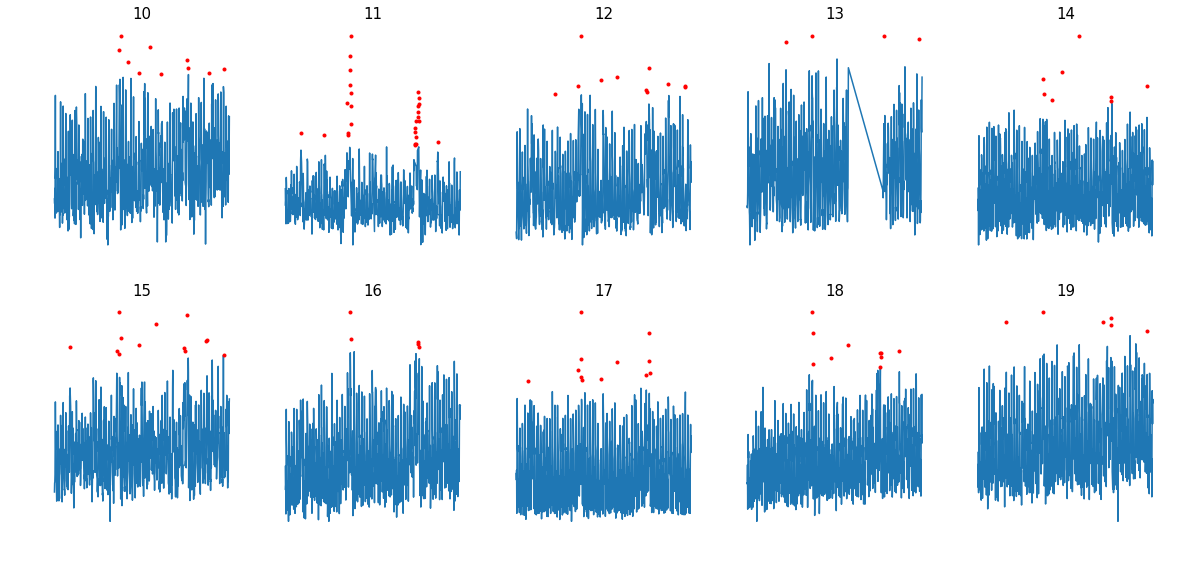

In [39]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(10,no_stores_to_check+10):
    stor = i

    # Normal sales
    X1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == False)]
    y1 = data.loc[ (data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == False)]['Sales']

    # Outliers
    X2 = data.loc[(data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == True)]
    y2 = data.loc[ (data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == True)]['Sales']

    Xt = data.loc[(data['Store'] == stor)]
    
    plt.subplot(10,5,i-9)
    plt.plot(X1['Date'], y1, '-' )
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i,fontsize = 15)
    plt.axis('off')

plt.xlabel('test')
plt.ylabel('test')
plt.show()

对店铺特征信息进行整理，并增加几个特征

In [45]:
#把数据中竞争对手开业时间转换成一个时间特征。
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan


#把数据中促销2开始的星期转换成开始的日子是一年中的第几天   
def Promo2BeginDay(row):
    try:
        Day = 1
        Week = int(row['Promo2SinceWeek'])
        DateDayOfYear = 7*(Week-1)+1
        return DateDayOfYear
    except:
        return np.nan



#把促销2的月份转换为数字    
promo2_intervals = {'Jan,Apr,Jul,Oct' : (1,4,7,10),
                    'Feb,May,Aug,Nov' : (2,5,8,11),
                    'Mar,Jun,Sept,Dec' :(3,6,9,12),
                    np.nan : np.nan

                   }    

#开始转换信息
store_feature['CompetitionOpenInt'] = store_feature.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)
store_feature['Promo2BeginDay'] = store_feature.apply(Promo2BeginDay,axis = 1)
store_feature['PromoInterval'] = store_feature['PromoInterval'].apply(lambda x: promo2_intervals[x])
#store_feature['CompetitionDistance'] = store_feature['CompetitionDistance'].apply(lambda x:Feature_Nomalization(x,'CompetitionDistance'))
store_feature["StoreType"] = store_feature["StoreType"].map({'a':0, 'b':1, 'c' :2, 'd':3})
store_feature["Assortment"] = store_feature["Assortment"].map({'a':0, 'b':1, 'c' :2})

#删除此表中无用的信息
storefeature_columns_to_drop = ['CompetitionOpenSinceMonth','Promo2SinceWeek']
store_feature = store_feature.drop(storefeature_columns_to_drop, axis = 1)


#为店铺增加几个特征
store_data_sales = data[data['Outlier'] == 0].groupby([data['Store']])['Sales'].sum()
store_data_customers = data[data['Outlier'] == 0].groupby([data['Store']])['Customers'].sum()
store_data_open = data[data['Outlier'] == 0].groupby([data['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day


store_feature = pd.merge(store_feature, store_data_sales_per_day.reset_index(name='SalesPerDay'), 
                         how='left', on=['Store'])
store_feature = pd.merge(store_feature, store_data_customers_per_day.reset_index(name='CustomersPerDay'), 
                         how='left', on=['Store'])
store_feature = pd.merge(store_feature, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), 
                         how='left', on=['Store'])

store_feature.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2BeginDay,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay
0,1,2,0,1270.0,2008.0,0,NaN,NaN,1220227200000000000,NaN,4700.459635,558.266927,8.419735
1,2,0,0,570.0,2007.0,1,2010.0,"(1, 4, 7, 10)",1193875200000000000,85.0,4899.493557,580.434278,8.441082
2,3,0,0,14130.0,2006.0,1,2011.0,"(1, 4, 7, 10)",1164931200000000000,92.0,6901.818065,747.060645,9.238632
3,4,2,2,620.0,2009.0,0,NaN,NaN,1251763200000000000,NaN,9493.392950,1307.275457,7.261968
4,5,0,0,29910.0,2015.0,0,NaN,NaN,1427846400000000000,NaN,4632.457956,534.360931,8.669155


两表合并前，对销售历史数据的日期进行处理，方便合并后的计算。

In [46]:

#对日期进行处理
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)
data['DateDayOfYear'] = data['Date'].apply(lambda x: x.dayofyear)

data['DateInt'] = data['Date'].astype(np.int64)


data['SalesLog']  = np.log1p(data['Sales'])


data.head(5)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Outlier,Year,Month,DateDayOfYear,DateInt,SalesLog
1016447,353,2,2013-01-01,3139,820,1,0,1,1,False,2013,1,1,1356998400000000000,8.051978
1016429,335,2,2013-01-01,2401,482,1,0,1,1,False,2013,1,1,1356998400000000000,7.784057
1016606,512,2,2013-01-01,2646,625,1,0,1,1,False,2013,1,1,1356998400000000000,7.881182
1016588,494,2,2013-01-01,3113,527,1,0,1,1,False,2013,1,1,1356998400000000000,8.043663
1016624,530,2,2013-01-01,2907,532,1,0,1,1,False,2013,1,1,1356998400000000000,7.975221


合并两张表的信息,并新建promo2_today（表明这天是否有促销2）这个特征

In [47]:
full_data = pd.merge(data, store_feature, how = 'left', on = ['Store'])

#通过销售日日期与促销2的信息，判断当天是否有促销2
def promo2_today(row):
    if row['Promo2'] == 1 and row['Year'] >= row['Promo2SinceYear']\
    and row['Month'] in row['PromoInterval']:
        return 1
    else:
        return 0



    
full_data['promo2_today'] = full_data.apply(promo2_today, axis = 1)

full_data.to_csv('full_data.csv')
full_data.head(5)



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Outlier,...,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2BeginDay,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,promo2_today
0,353,2,2013-01-01,3139,820,1,0,1,1,False,...,2001.0,1,2013.0,"(2, 5, 8, 11)",978307200000000000,92.0,5571.336254,1439.847755,3.869393,0
1,335,2,2013-01-01,2401,482,1,0,1,1,False,...,2001.0,1,2013.0,"(1, 4, 7, 10)",978307200000000000,211.0,13277.168085,2382.040426,5.573863,1
2,512,2,2013-01-01,2646,625,1,0,1,1,False,...,2001.0,1,2013.0,"(3, 6, 9, 12)",978307200000000000,29.0,5422.256552,1278.616552,4.240721,0
3,494,2,2013-01-01,3113,527,1,0,1,1,False,...,2011.0,0,NaN,NaN,1306886400000000000,NaN,7636.980851,1078.752128,7.079458,0
4,530,2,2013-01-01,2907,532,1,0,1,1,False,...,2001.0,0,NaN,NaN,978307200000000000,NaN,4589.805556,744.264444,6.166902,0


## 数据可视化
读取一个店铺一个月的销量，获得一个直观印象。销量大概是以周为时间单位波动的

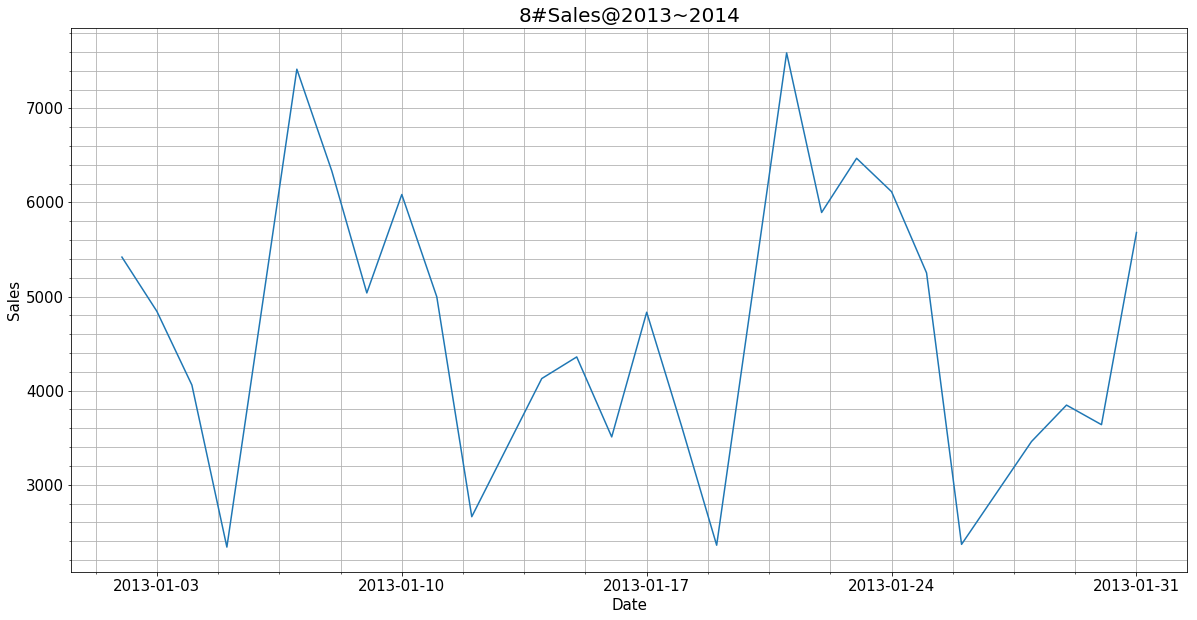

In [48]:
plt.rcParams["figure.figsize"] = [20,10]
stor = 8

X1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1)&(data['Date']<'2013-2-1')]
y1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1)&(data['Date']<'2013-2-1')]['Sales']
Xt = data.loc[(data['Store'] == stor)]    
plt.plot(X1['Date'], y1, '-', )
plt.minorticks_on()
plt.grid(True, which='both')

plt.title('8#Sales@2013~2014', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()


节假日、促销这些特征对销售量确实有一定影响，但有些影响不是特别大

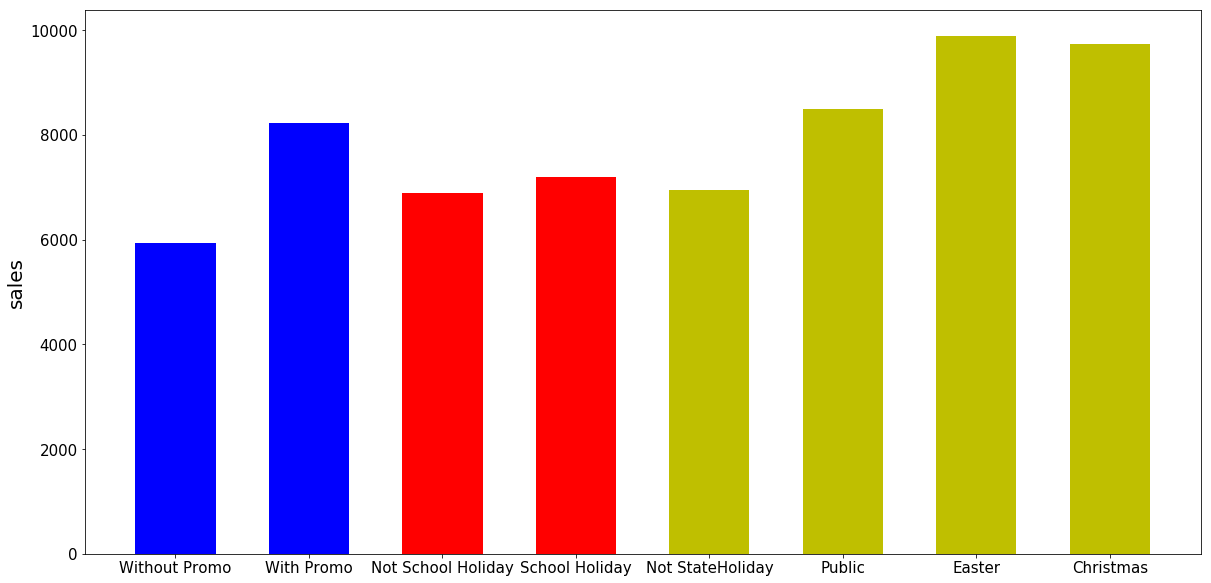

In [49]:

average_sales_pro1 = data.groupby('Promo')['Sales'].mean()
average_sales_schoolholiday = data.groupby('SchoolHoliday')['Sales'].mean()
average_sales_holiday = data.groupby('StateHoliday')['Sales'].mean()
plt.bar(average_sales_pro1.index, average_sales_pro1,width = 0.6, align = 'center' , color = 'b')
plt.bar(average_sales_schoolholiday.index+2,average_sales_schoolholiday,width = 0.6, align = 'center', color = 'r')
plt.bar(average_sales_holiday.index+4, average_sales_holiday,width = 0.6, align = 'center', color = 'y')
plt.xticks(range(8), ('Without Promo', 'With Promo', 'Not School Holiday', 'School Holiday', 'Not StateHoliday','Public', 'Easter', 'Christmas'),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('sales', fontsize = 20)
plt.show()

查看店铺类型对销量的影响情况

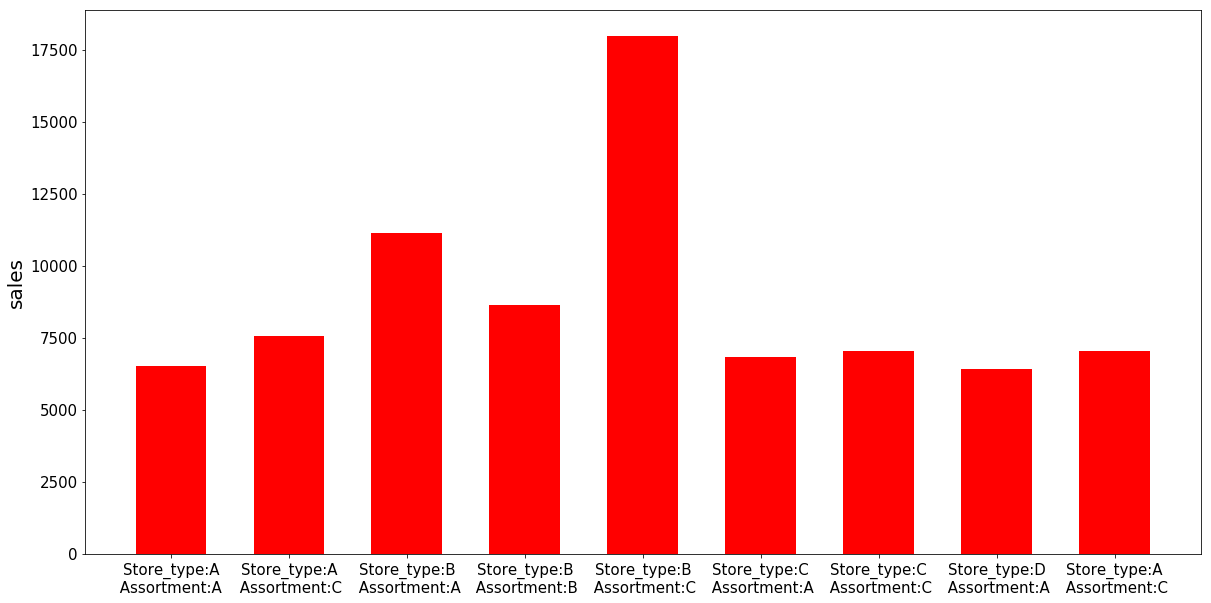

In [50]:
full_data = pd.read_csv('full_data.csv') 
full_data = full_data[full_data['Open'] == 1]
plt.rcParams["figure.figsize"] = [20,10]
a = full_data.groupby(['StoreType','Assortment'])['Sales'].mean()
plt.bar(range(9),a,width = 0.6, align = 'center', color = 'r')
index = ('Store_type:A\n Assortment:A ', 'Store_type:A\n Assortment:C', 'Store_type:B\n Assortment:A', 'Store_type:B\n Assortment:B',
        'Store_type:B\n Assortment:C', 'Store_type:C\n Assortment:A', 'Store_type:C\n Assortment:C', 
         'Store_type:D\n Assortment:A', 'Store_type:A\n Assortment:C',)
plt.xticks(range(9), index, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('sales', fontsize = 20)
plt.show()

## 训练
接下来就要用数据进行训练了.首先使用随机森林算法进行.
### 随机森林
在进行训练前，删除无用数据

In [91]:
#只选出开业和数据正常的数据
full_data = pd.read_csv('full_data.csv',
                        parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
                       ) 
full_data = full_data.drop('Unnamed: 0', axis = 1)


newdata = full_data[full_data['Open'] == 1]


    
newdata = newdata.loc[~(newdata['Outlier'] == True)]


newdata_columns_to_drop = ['Promo2', 'Promo2SinceYear', 
                            'PromoInterval', 'CompetitionOpenSinceYear', 
                            'Promo2BeginDay','Customers',
                           'Outlier'      ,'Open' , 'DateInt'
                           ]

newdata = newdata.drop(newdata_columns_to_drop, axis = 1)




newdata.head(5)

#df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes 独热编码的另外一种办法

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,DateDayOfYear,SalesLog,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,promo2_today
0,353,2,2013-01-01,3139,0,1,1,2013,1,1,8.051978,1,1,900.0,978307200000000000,5571.336254,1439.847755,3.869393,0
1,335,2,2013-01-01,2401,0,1,1,2013,1,1,7.784057,1,0,90.0,978307200000000000,13277.168085,2382.040426,5.573863,1
2,512,2,2013-01-01,2646,0,1,1,2013,1,1,7.881182,1,1,590.0,978307200000000000,5422.256552,1278.616552,4.240721,0
3,494,2,2013-01-01,3113,0,1,1,2013,1,1,8.043663,1,0,1260.0,1306886400000000000,7636.980851,1078.752128,7.079458,0
4,530,2,2013-01-01,2907,0,1,1,2013,1,1,7.975221,0,2,18160.0,978307200000000000,4589.805556,744.264444,6.166902,0


评价参数函数

In [92]:
def performance_metric(y_true, y_pred): 
    y_true = y_true.astype(float)
    y_pred = y_pred.astype(float)

    return   (np.mean(((y_true-y_pred)/y_true)**2)) **0.5

把数据分为训练和验证集

In [93]:
train_data = newdata
X_all = train_data.drop(['Sales','SalesLog'], axis = 1)
Y_all = train_data['Sales']
#X_all = preprocessing.scale(X_train)
#Y_all = preprocessing.scale(Y_train)
# TODO: 把数据分为训练和验证集
X = X_all.iloc[:-42*1115]
Y = Y_all.iloc[:-42*1115]
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, train_size=0.95,random_state= seed)
X_test = X_all[-42*1115:]
Y_test = Y_all[-42*1115:]

x_train = X_train.drop(['Date'],axis = 1).values
x_valid = X_valid.drop(['Date'],axis = 1).values
x_test = X_test.drop(['Date'],axis = 1).values
y_train = Y_train.values
y_valid = Y_valid.values
y_test = Y_test.values

开始训练并打印得分

In [94]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state= seed)

  
model.fit(x_train, y_train)
Y_pred = model.predict(x_train)
a = performance_metric(y_train,Y_pred)

Y_pred = model.predict(x_valid)
b = performance_metric(y_valid, Y_pred)
Y_pred = model.predict(x_test)
c = performance_metric(y_test,Y_pred)

print ("RandomForest Test score is : {:,.6f}".format(a))
print ("RandomForest Validate score is : {:,.6f}".format(b))
print ("RandomForest Test score is : {:,.6f}".format(c))

RandomForest Test score is : 0.083630
RandomForest Validate score is : 0.116038
RandomForest Test score is : 0.141674


特征重要性可视化

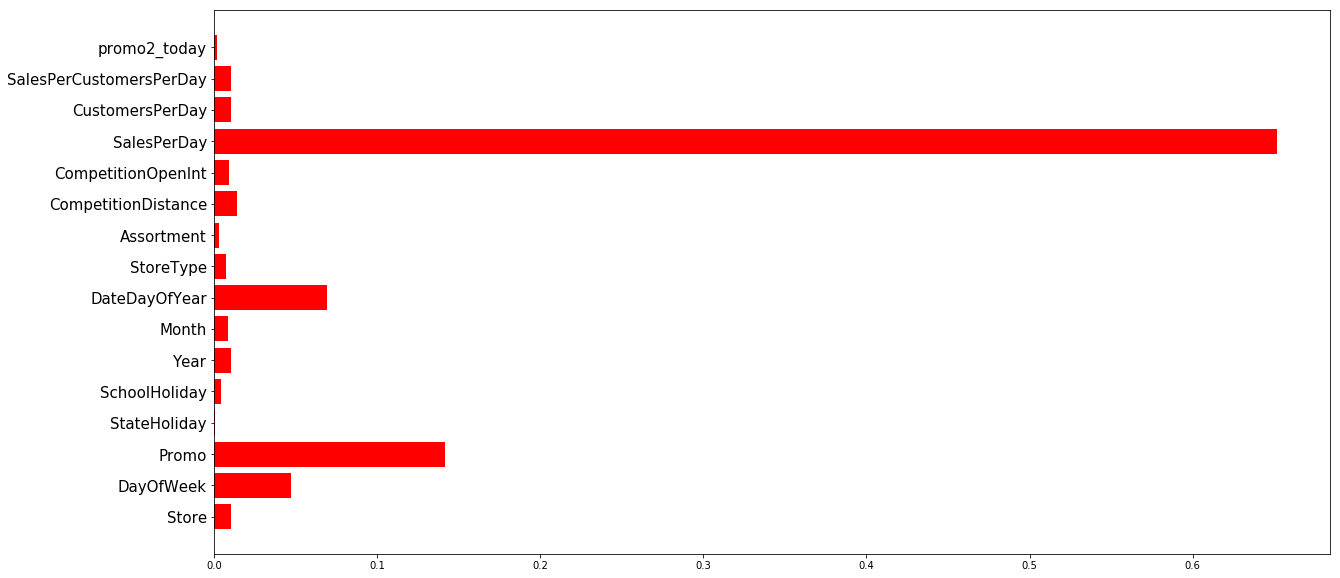

In [95]:
a = model.feature_importances_
b = a
X = train_data.drop(['Sales','SalesLog'], axis = 1)
index = X_train.drop(['Date'],axis = 1).columns
plt.rcParams["figure.figsize"] = [20,10]
plt.barh(range(len(b)),b,align = 'center', color = 'r')
plt.yticks(range(len(b)), index, fontsize = 15)
plt.show()

使用网格搜索技术寻找更佳参数

In [100]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state= seed)
parameters = {'n_estimators' :[50], 'min_samples_split' : [5]}
grid_obj = GridSearchCV(estimator=model ,param_grid=parameters, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)
best_clf = grid_obj.best_estimator_
best_parameter = grid_obj.best_params_

In [101]:
Y_pred = best_clf.predict(x_valid)
b = performance_metric(y_valid, Y_pred)
print ("RandomForest Valid score after tunning is : {:,.6f}".format(b))
Y_pred = best_clf.predict(x_test)
c = performance_metric(y_test, Y_pred)
print ("RandomForest Test score after tunning is : {:,.6f}".format(c))
print ('Best parameter is:')
print (best_parameter)

RandomForest Valid score after tunning is : 0.110657
RandomForest Test score after tunning is : 0.141803
Best parameter is:
{'min_samples_split': 5, 'n_estimators': 50}


预测结果可视化

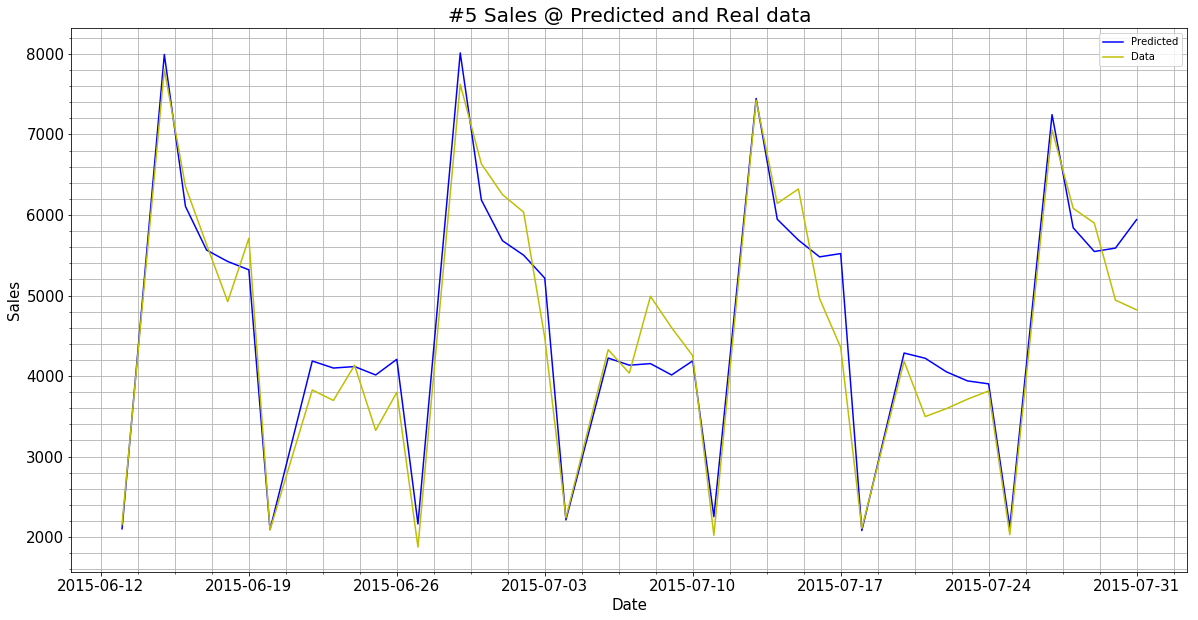

In [103]:
store_num = 5
X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = best_clf.predict(X_test.drop(['Date'],axis = 1)[(X_test['Store'] == store_num)].values)
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

### 前向神经网络
在进行训练前，删除无用数据，并且对数据进行归一化

In [75]:
full_data = pd.read_csv('full_data.csv',
                        parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
                       )  
full_data = full_data.drop('Unnamed: 0', axis = 1)
newdata = full_data[full_data['Open'] == 1]


newdata = newdata.loc[~(newdata['Outlier'] == True)]


newdata_columns_to_norm = ['CompetitionDistance','SalesPerDay','CustomersPerDay','SalesPerCustomersPerDay']
newdata[newdata_columns_to_norm] = newdata[newdata_columns_to_norm].apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))


newdata_columns_to_drop = ['Promo2', 'Promo2SinceYear', 
                            'PromoInterval', 'CompetitionOpenSinceYear', 
                             'Promo2BeginDay','Customers', 'CompetitionOpenInt',
                           'Year','Month','Open', 'Outlier'   ,'Date'    ,'Store'  ,'DateInt'   
                           ]

newdata = newdata.drop(newdata_columns_to_drop, axis = 1)

#进行独热编码

newdata = pd.get_dummies(newdata,columns = ['StateHoliday','StoreType', 'Assortment','DayOfWeek'])

newdata.to_csv('newdata.csv')
newdata.head(5)

,Sales,Promo,SchoolHoliday,DateDayOfYear,SalesLog,CompetitionDistance,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,promo2_today,...,Assortment_0,Assortment_1,Assortment_2,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,3139,0,1,1,8.051978,0.011864,0.151137,0.379653,0.028646,0,...,0,1,0,0,1,0,0,0,0,0
1,2401,0,1,1,7.784057,0.001186,0.553882,0.677092,0.163955,1,...,1,0,0,0,1,0,0,0,0,0
2,2646,0,1,1,7.881182,0.007777,0.143345,0.328755,0.058124,0,...,0,1,0,0,1,0,0,0,0,0
3,3113,0,1,1,8.043663,0.016610,0.259098,0.265660,0.283476,0,...,1,0,0,0,1,0,0,0,0,0
4,2907,0,1,1,7.975221,0.239388,0.099837,0.160066,0.211033,0,...,0,0,1,0,1,0,0,0,0,0


创建训练集、验证集、测试集

In [76]:
newdata = pd.read_csv("newdata.csv")
train_data = newdata.drop('Unnamed: 0', axis = 1)

X_all = train_data.drop(['Sales','SalesLog'], axis = 1).values
Y_all = train_data['Sales'].values
X = X_all[:-42*1115]
Y = Y_all[:-42*1115]
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, train_size=0.95,random_state= 3)
X_test = X_all[-42*1115:]
Y_test = Y_all[-42*1115:]
train_data.head(5)

,Sales,Promo,SchoolHoliday,DateDayOfYear,SalesLog,CompetitionDistance,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,promo2_today,...,Assortment_0,Assortment_1,Assortment_2,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,3139,0,1,1,8.051978,0.011864,0.151137,0.379653,0.028646,0,...,0,1,0,0,1,0,0,0,0,0
1,2401,0,1,1,7.784057,0.001186,0.553882,0.677092,0.163955,1,...,1,0,0,0,1,0,0,0,0,0
2,2646,0,1,1,7.881182,0.007777,0.143345,0.328755,0.058124,0,...,0,1,0,0,1,0,0,0,0,0
3,3113,0,1,1,8.043663,0.016610,0.259098,0.265660,0.283476,0,...,1,0,0,0,1,0,0,0,0,0
4,2907,0,1,1,7.975221,0.239388,0.099837,0.160066,0.211033,0,...,0,0,1,0,1,0,0,0,0,0


神经网络的评价函数

In [78]:
from keras import backend as K
def performance_metric_neu(y_true, y_pred): 
    y = K.sqrt((K.mean(K.square((y_true-y_pred)/y_true))))
    return 100*y



创建网络

In [86]:
seed = 4
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import initializers

model = Sequential()
model.add(Dense(56, input_dim=X.shape[1], kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(56, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(56, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(1, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed)))
model.summary()
model.compile(loss=performance_metric_neu, optimizer='adam', metric = performance_metric_neu)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 56)                1512      
_________________________________________________________________
dense_10 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_11 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 57        
Total params: 7,953.0
Trainable params: 7,953
Non-trainable params: 0.0
_________________________________________________________________


开始训练

In [88]:
from keras.callbacks import ModelCheckpoint  ,EarlyStopping, ReduceLROnPlateau


epochs = 300

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
stopping = EarlyStopping(monitor = 'val_loss',patience = 15, verbose = 1, mode = 'auto')
rd =  ReduceLROnPlateau(verbose = 1,patience = 5, factor = 0.5)
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          epochs=epochs, batch_size=256, callbacks=[checkpointer,rd], verbose=1)



Train on 745302 samples, validate on 39227 samples
Epoch 1/300
745302/745302 [==============================] - 7s - loss: 17.4612 - val_loss: 17.5548
Epoch 2/300
745302/745302 [==============================] - 7s - loss: 17.8258 - val_loss: 17.5318
Epoch 3/300
745302/745302 [==============================] - 7s - loss: 17.4356 - val_loss: 17.5750
Epoch 4/300
745302/745302 [==============================] - 7s - loss: 17.5704 - val_loss: 18.6073
Epoch 5/300
745302/745302 [==============================] - 7s - loss: 18.0416 - val_loss: 17.0744
Epoch 6/300
745302/745302 [==============================] - 7s - loss: 17.4669 - val_loss: 17.4347
Epoch 7/300
745302/745302 [==============================] - 7s - loss: 17.5675 - val_loss: 17.0533
Epoch 8/300
745302/745302 [==============================] - 6s - loss: 17.7839 - val_loss: 17.0616
Epoch 9/300
745302/745302 [==============================] - 7s - loss: 17.5129 - val_loss: 17.3898
Epoch 10/300
745302/745302 [=====================

745302/745302 [==============================] - 7s - loss: 17.1191 - val_loss: 16.8465
Epoch 36/300
745302/745302 [==============================] - 6s - loss: 17.1122 - val_loss: 16.8573
Epoch 37/300
745302/745302 [==============================] - 6s - loss: 17.1541 - val_loss: 16.9392
Epoch 38/300
745302/745302 [==============================] - 6s - loss: 17.1335 - val_loss: 16.8757
Epoch 39/300
745302/745302 [==============================] - 7s - loss: 17.1122 - val_loss: 16.8144
Epoch 40/300
745302/745302 [==============================] - 7s - loss: 17.1606 - val_loss: 16.8259
Epoch 41/300
745302/745302 [==============================] - 7s - loss: 17.1029 - val_loss: 16.8511
Epoch 42/300
264704/745302 [=========>....................] - ETA: 4s - loss: 16.9975

KeyboardInterrupt: 

查看模型得分

In [90]:
model.load_weights('weights.best.hdf5')
pred = model.predict(X_train)
a = performance_metric(pred.flatten(), Y_train)
print ("Neural Network Train score is : {:,.6f}".format(a))
model.load_weights('weights.best.hdf5')
pred = model.predict(X_valid)
a = performance_metric(pred.flatten(), Y_valid)
print ("Neural Network Valid score is : {:,.6f}".format(a))
model.load_weights('weights.best.hdf5')
pred = model.predict(X_test)
a = performance_metric(pred.flatten(), Y_test)
print ("Neural Network Test score is : {:,.6f}".format(a))

Neural Network Train score is : 0.194480
Neural Network Valid score is : 0.193549
Neural Network Test score is : 0.200362


### XGBoost
在进行训练前，删除无用数据

In [65]:
newdata = pd.read_csv('full_data.csv',
                        parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
                       ) 
newdata = newdata[newdata['Open'] == 1]    
newdata = newdata.loc[~(newdata['Outlier'] == True)]

train_data = newdata
features_x = ['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','DateDayOfYear','StoreType','Assortment',
                      'promo2_today', 'SalesPerCustomersPerDay','Date',
              'CustomersPerDay', 'SalesPerDay', 'CompetitionDistance', 'Year', 'Month','DateInt', 'CompetitionOpenInt']

X_all = train_data[features_x]
Y_all = train_data['Sales']

# TODO: 把数据分为训练和验证集
X = X_all[:-42*1115]
Y = Y_all[:-42*1115]
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, train_size=0.95,random_state= 3)
X_test = X_all[-42*1115:]
Y_test = Y_all[-42*1115:]

x_train = X_train.drop(['Date'],axis = 1)

x_valid = X_valid.drop(['Date'],axis = 1)

x_test = X_test.drop(['Date'],axis = 1)


X_train.head(10)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,DateDayOfYear,StoreType,Assortment,promo2_today,SalesPerCustomersPerDay,Date,CustomersPerDay,SalesPerDay,CompetitionDistance,Year,Month,DateInt,CompetitionOpenInt
221974,994,3,1,0,1,240,0,0,0,10.195079,2013-08-28,438.410390,4469.628571,2290.0,2013,8,1377648000000000000,1309478400000000000
110876,896,2,1,0,0,120,0,2,0,6.334642,2013-04-30,1063.761015,6738.544726,170.0,2013,4,1367280000000000000,1346457600000000000
243760,427,5,0,0,0,263,0,2,0,9.747367,2013-09-20,756.795000,7376.758333,70.0,2013,9,1379635200000000000,1120176000000000000
78876,813,1,1,0,1,84,0,0,0,8.918316,2013-03-25,647.729167,5776.653646,1560.0,2013,3,1364169600000000000,1062374400000000000
425207,182,4,1,0,0,93,3,2,0,12.652665,2014-04-03,414.255844,5241.440260,1390.0,2014,4,1396483200000000000,978307200000000000
155824,214,4,1,0,0,171,3,0,0,13.012631,2013-06-20,711.684416,9260.887013,8650.0,2013,6,1371686400000000000,1372636800000000000
142167,553,4,1,0,0,157,2,0,0,11.016748,2013-06-06,634.328145,6988.233463,3040.0,2013,6,1370476800000000000,1030838400000000000
531091,256,1,1,0,1,216,0,2,0,7.837401,2014-08-04,1233.515748,9667.557743,80.0,2014,8,1407110400000000000,1125532800000000000
755132,679,6,0,0,0,115,0,0,0,9.339781,2015-04-25,1055.010336,9853.565891,4140.0,2015,4,1429920000000000000,1346457600000000000
184064,978,5,1,0,1,200,2,2,0,7.367776,2013-07-19,958.114474,7059.172368,3890.0,2013,7,1374192000000000000,978307200000000000


评价函数

In [66]:

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    #y = np.exp(y) - 1
    #yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe



In [67]:
dtrain = xgb.DMatrix(x_train, Y_train)
dtest = xgb.DMatrix(x_valid, Y_valid)
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [68]:

param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmspe:0.685823	test-rmspe:0.685002
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmspe:0.165221	test-rmspe:0.12715
[500]	train-rmspe:0.157397	test-rmspe:0.113274
[750]	train-rmspe:0.152693	test-rmspe:0.10709
[1000]	train-rmspe:0.149427	test-rmspe:0.104289
[1250]	train-rmspe:0.147456	test-rmspe:0.102445
[1500]	train-rmspe:0.14615	test-rmspe:0.101276
[1750]	train-rmspe:0.143933	test-rmspe:0.100076
[2000]	train-rmspe:0.140684	test-rmspe:0.099301
[2250]	train-rmspe:0.139385	test-rmspe:0.09887
[2500]	train-rmspe:0.139846	test-rmspe:0.098568
[2750]	train-rmspe:0.138603	test-rmspe:0.098115
[3000]	train-rmspe:0.137423	test-rmspe:0.097928
[3250]	train-rmspe:0.136547	test-rmspe:0.097824
[3500]	train-rmspe:0.130623	test-rmspe:0.097863
Stopping. Best iteration:
[3311]	train-rmspe:0.136371	test-rmspe:0.097781



In [69]:
ypred = xgb.DMatrix(x_test)
ypred = bst1.predict(ypred)
a=performance_metric(Y_test .values,ypred)
print ("XGBoost Test score is : {:,.6f}".format(a))

XGBoost Test score is : 0.132363


预测结果可视化

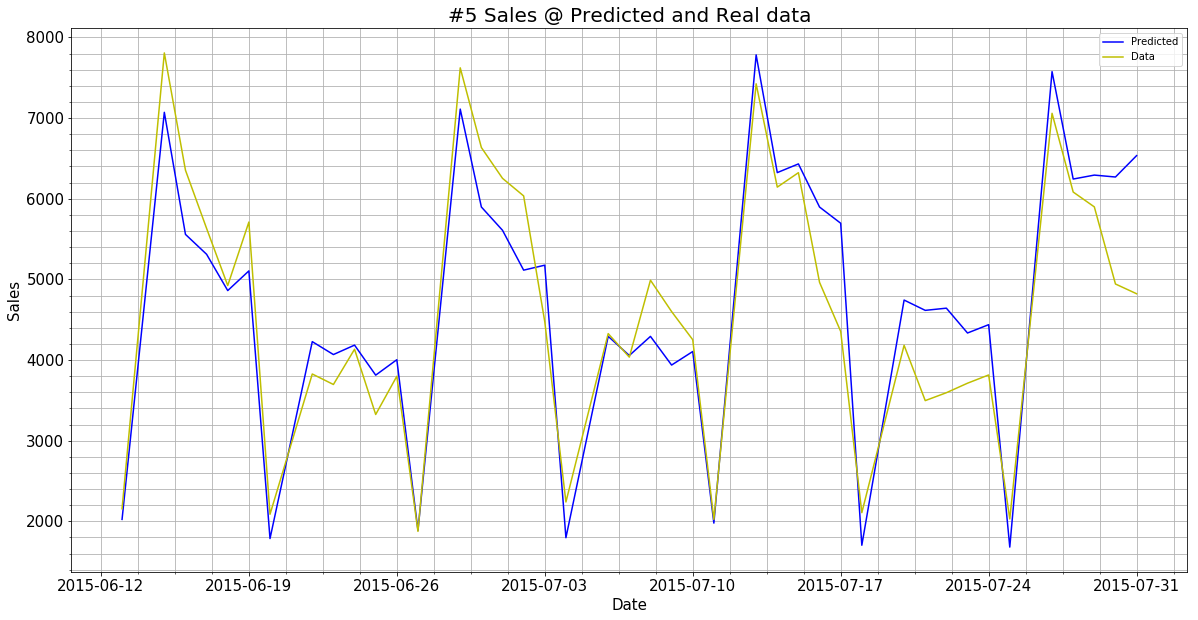

In [70]:

store_num = 5
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])

X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

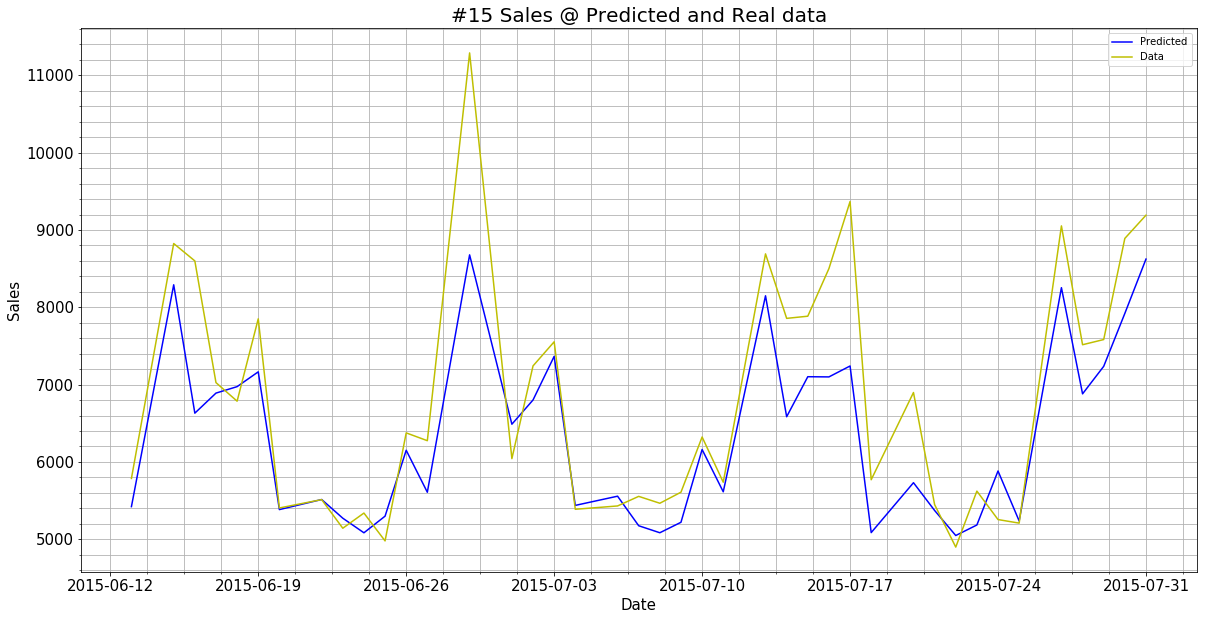

In [71]:
store_num = 15
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])

X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

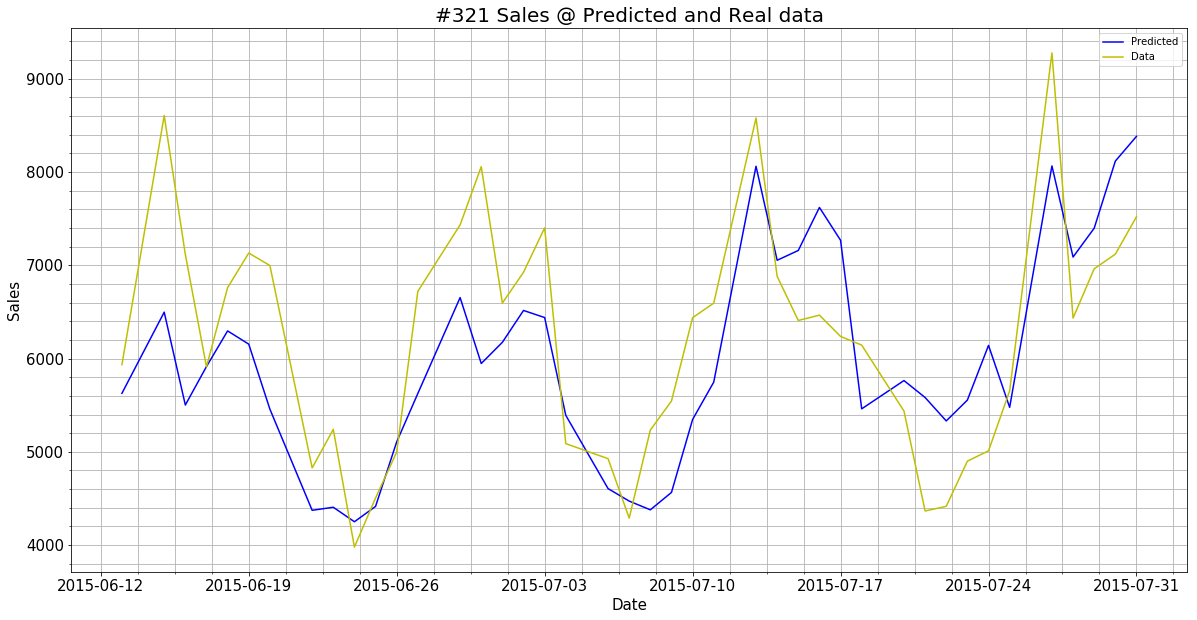

In [72]:
store_num = 321
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])

X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

XGBoost特征重要性

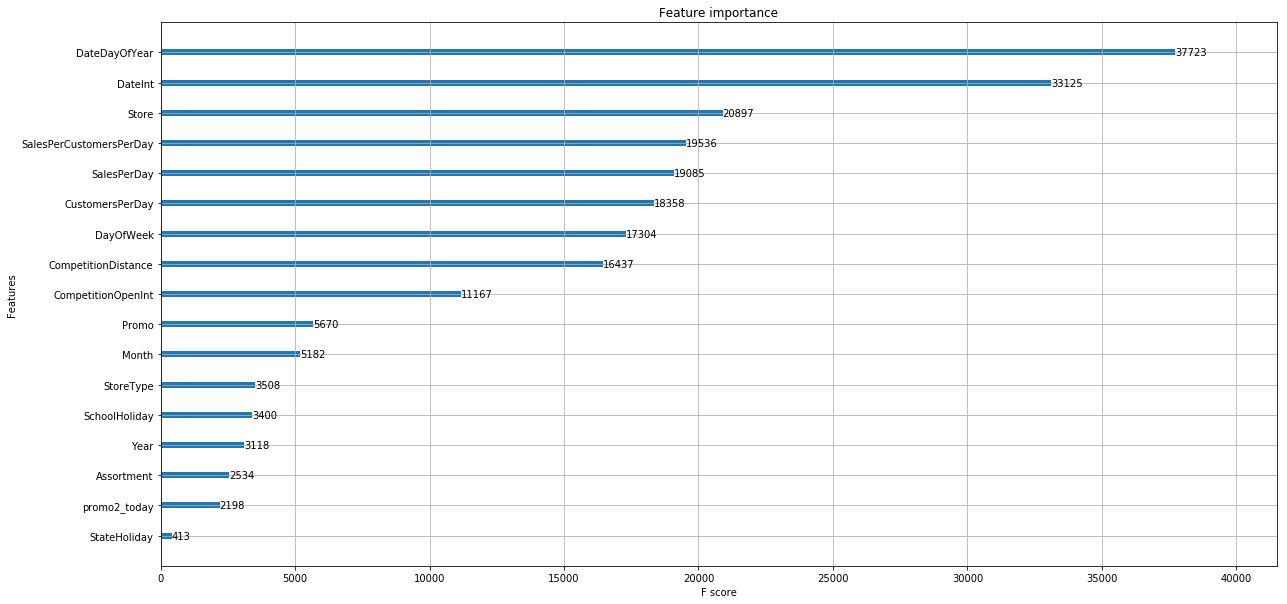

In [73]:
xgb.plot_importance(bst1)  
plt.show()  